In [34]:
import optuna
from keras.optimizers import Adam, RMSprop
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [35]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\ic2594\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [36]:
sol = data.load_asset('SOLUSDT', sampling='1d')
sol = data.add_fear_and_greed(sol)
# Restrict data after 2022
sol = sol[sol.index >= '2020-01-01']
sol.head()

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2020-08-11,2.8500,3.5208,2.8433,3.2985,1552384.78,4.939149e+06,13490,741770.79,2.370193e+06,84.0,Extreme Greed
2020-08-12,3.2985,3.9289,3.0800,3.7558,1737042.95,6.176154e+06,21118,889133.50,3.161944e+06,75.0,Greed
2020-08-13,3.7500,4.1387,3.5003,3.7300,1685759.24,6.446568e+06,22922,716358.46,2.755765e+06,75.0,Greed
2020-08-14,3.7207,3.7676,3.3210,3.4099,1474161.79,5.205834e+06,18581,578651.84,2.048897e+06,78.0,Extreme Greed
2020-08-15,3.4181,3.7400,3.1500,3.1730,1070233.20,3.658006e+06,13903,439623.97,1.510473e+06,79.0,Extreme Greed


In [37]:
sol.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume', 'F&G', 'F&G category'],
      dtype='object')

In [38]:
import numpy as np
import pandas as pd
import ta  # pip install ta

def compute_slope(series):
    y = series.values
    x = np.arange(len(y))
    if len(y) == 0:
        return np.nan
    return np.polyfit(x, y, 1)[0]

def add_technical_features(df, look_back=14):
    df = df.copy()  # avoid modifying original

    # Return: Daily log return
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Risk: Rolling std dev (volatility)
    df['Risk'] = df['Return'].rolling(window=look_back).std()

    # RSI
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=look_back).rsi()

    # ADX
    df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=look_back).adx()

    # Momentum
    df['MOM'] = df['Close'] - df['Close'].shift(look_back)

    # High-low spread
    df['HL'] = df['High'] - df['Low']

    # High-open & low-open
    df['HO'] = df['High'] - df['Open']
    df['LO'] = df['Low'] - df['Open']

    # Buy pressure ratio
    df['buy_pressure_ratio'] = df['Taker buy quote asset volume'] / df['Quote asset volume']

    # Trades per volume
    df['trades_per_volume'] = df['Number of trades'] / df['Quote asset volume']

    # Rolling slope
    df['slope'] = df['Close'].rolling(window=look_back).apply(compute_slope, raw=False)

    # Drop NaN from lookback window
    df = df.dropna()

    # Drop unnecessary columns
    cols_to_drop = [
        'Open', 'High', 'Low', 'Quote asset volume',
        'Number of trades', 'Taker buy base asset volume',
        'Taker buy quote asset volume', 'F&G'
    ]
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    return df


In [39]:
sol = add_technical_features(sol)
sol.head()

,Close,Volume,F&G category,Return,Risk,RSI,ADX,MOM,HL,HO,LO,buy_pressure_ratio,trades_per_volume,slope
Open time,,,,,,,,,,,,,,
2020-08-25,3.2500,1149187.37,Greed,-0.027466,0.085476,49.797443,0.0,-0.0485,0.3653,0.0248,-0.3405,0.414953,0.003919,-0.034897
2020-08-26,3.5684,2290030.56,Extreme Greed,0.093462,0.081659,57.152129,0.0,-0.1874,0.6190,0.5423,-0.0767,0.548917,0.002973,-0.010371
2020-08-27,3.4501,2412974.80,Greed,-0.033714,0.082054,53.987465,0.0,-0.2799,0.6141,0.3018,-0.3123,0.482751,0.003006,0.010749
2020-08-28,4.0063,2581936.84,Greed,0.149465,0.087879,64.062997,0.0,0.5964,0.8588,0.8588,0.0000,0.548365,0.003016,0.038438
2020-08-29,3.9535,1342844.20,Extreme Greed,-0.013267,0.084938,62.660274,0.0,0.7805,0.3373,0.1051,-0.2322,0.440181,0.003651,0.054187


In [40]:
sol.columns

Index(['Close', 'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
       'MOM', 'HL', 'HO', 'LO', 'buy_pressure_ratio', 'trades_per_volume',
       'slope'],
      dtype='object')

In [41]:
def prep_data(df, sequence_length=60, test_size=0.2):
    # 1) include 'Close' since that's what we'll predict
    features = [
        'Close',      # ← our prediction target
        'Volume', 'F&G category', 'Return', 'Risk', 'RSI', 'ADX',
        'MOM', 'HL', 'HO', 'LO',
        'buy_pressure_ratio', 'trades_per_volume', 'slope'
    ]
    
    # 2) split numeric vs cat\egorical
    num_feats = [f for f in features if f != 'F&G category']
    df_num = df[num_feats]
    df_cat = pd.get_dummies(df['F&G category'], prefix='F_G')
    
    # 3) combine & scale
    df_all = pd.concat([df_num, df_cat], axis=1).dropna()
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(df_all.values)
    feature_names = df_all.columns.tolist()
    
    # 4) build sequences for time-series
    target_idx = feature_names.index('Close')
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i-sequence_length:i])
        # y is the scaled Close price at time i (next day)
        y.append(data_scaled[i, target_idx])
    X, y = np.array(X), np.array(y)
    
    # 5) train/test split (preserving time order)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    return (X_train, X_test, y_train, y_test), scaler



In [42]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ——— Hyperparameters (from Optuna) ———
UNITS_L0      = 160
DROPOUT_L0    = 0.0
LEARNING_RATE = 0.0007280355873484089
OPTIMIZER     = Adam(learning_rate=LEARNING_RATE)
BATCH_SIZE    = 32
MAX_EPOCHS    = 50

def train_lstm_for_asset(df, sequence_length=30, test_size=0.2):
    # … prep_data as before …
    (X_train, X_val, y_train, y_val), scaler = prep_data(
        df, sequence_length=sequence_length, test_size=test_size
    )
    
    # Build the model
    model = Sequential([
        Input(shape=X_train.shape[1:]),
        LSTM(UNITS_L0, return_sequences=False, dropout=DROPOUT_L0),
        Dense(1, activation='linear')
    ])
    
    # *** instantiate a new optimizer here, not reuse a global one ***
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=MAX_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=1
    )
    
    return model, scaler, history, (X_val, y_val)

# Example usage for any asset DataFrame `asset_df`:
# model, scaler, history, (X_val, y_val) = train_lstm_for_asset(asset_df)

# And to plot predictions vs actual:
# preds = model.predict(X_val).flatten()
# plt.figure(figsize=(10,5))
# plt.plot(y_val,  label='Actual Close (scaled)')
# plt.plot(preds, label='Predicted Close (scaled)')
# plt.legend()
# plt.title("LSTM Forecast (Scaled)")
# plt.show()

In [43]:
df = data.load_asset('UNIUSDT', sampling='1d')
df

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
Open time,,,,,,,,,
2020-09-17,0.3000,15.0000,0.3000,3.4617,1.025972e+08,3.337291e+08,660780,49916784.87,1.631750e+08
2020-09-18,3.4618,8.6000,3.2285,6.9000,1.676679e+08,1.000040e+09,1486593,85283759.81,5.082391e+08
2020-09-19,6.9000,7.4963,5.1900,5.7244,7.981451e+07,5.154502e+08,979043,38099403.63,2.465185e+08
2020-09-20,5.7244,6.0900,4.6500,5.2230,5.351973e+07,2.826816e+08,592785,26051761.15,1.376086e+08
2020-09-21,5.2200,5.6500,4.0600,4.2471,5.611050e+07,2.632497e+08,540477,26954893.82,1.263400e+08
...,...,...,...,...,...,...,...,...,...
2025-03-27,6.7240,6.9090,6.6510,6.7250,2.640107e+06,1.792577e+07,77911,1011624.93,6.874608e+06
2025-03-28,6.7270,6.8380,6.0490,6.1740,3.605760e+06,2.275314e+07,90664,1485113.51,9.353470e+06
2025-03-29,6.1740,6.2550,5.8630,5.9600,2.808038e+06,1.703279e+07,77417,1236609.43,7.490245e+06


In [44]:
import os
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import load_model

# 1. Ensure eager mode for compatibility (if you set run_eagerly earlier)
tf.config.run_functions_eagerly(True)

# 2. Directories to save models and scalers
os.makedirs('models', exist_ok=True)
os.makedirs('scalers', exist_ok=True)

# 3. List of asset tickers
assets = ['SOLUSDT', 'BTCUSDT', 'ETHUSDT', 'DOGEUSDT', 'XRPUSDT']
results = {}

for ticker in assets:
    # 4a) Load & feature-engineer
    df = data.load_asset(ticker, sampling='1d')
    df = data.add_fear_and_greed(df)
    df = add_technical_features(df)
    df = df[(df.index >= '2022-01-01') & (df.index <= '2023-12-31')]

    # 4b) Train the LSTM
    model, scaler, history, (X_val, y_val) = train_lstm_for_asset(df)

    # 4c) Save model and scaler
    model_path  = f'models/{ticker}_lstm_model.h5'
    scaler_path = f'scalers/{ticker}_scaler.pkl'
    model.save(model_path)
    joblib.dump(scaler, scaler_path)

    # 4d) Store paths and validation data
    results[ticker] = {
        'model_path':  model_path,
        'scaler_path': scaler_path,
        'history':     history,
        'X_val':       X_val,
        'y_val':       y_val
    }

# 5. Compute and print validation RMSE for each asset
for ticker, res in results.items():
    # Load model (if not in memory) and validation data
    model = load_model(res['model_path'])
    X_val = res['X_val']
    y_val = res['y_val']

    # Predict and score
    preds = model.predict(X_val).flatten()
    rmse  = np.sqrt(mean_squared_error(y_val, preds))
    print(f"{ticker} validation RMSE (scaled): {rmse:.4f}")


Epoch 1/50
 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0682 

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0441 - val_loss: 0.0034
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 8.5972e-04 - val_loss: 0.0013
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 7.6346e-04 - val_loss: 0.0016
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 6.8758e-04 - val_loss: 0.0014
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 6.7386e-04 - val_loss: 0.0018
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 5.7270e-04 - val_loss: 0.0015
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 5.3273e-04 - val_loss: 0.0016


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0525 - val_loss: 0.0232
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 0.0084 - val_loss: 0.0077
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0033 - val_loss: 0.0072
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0012 - val_loss: 0.0052
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0014 - val_loss: 0.0038
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.

Epoch 1/50
 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.1698

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0788 - val_loss: 0.0097
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0149 - val_loss: 0.0251
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0013 - val_loss: 0.0038


Epoch 1/50


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0431 - val_loss: 0.0018
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0070 - val_loss: 0.0014
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - loss: 0.0024 - val_loss: 9.6845e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 0.0017 - val_loss: 7.5966e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 230ms/step - loss: 0.0014 - val_loss: 8.6823e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 219ms/step - loss: 0.0012 - val_loss: 9.0200e-04
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step

Epoch 1/50


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.0292 - val_loss: 0.0080
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - loss: 0.0069 - val_loss: 0.0020
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 227ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - loss: 0.0024 - val_loss: 0.0019
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 221ms/step - loss: 0.0022 - val_loss: 0.0019


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


SOLUSDT validation RMSE (scaled): 0.0362
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
BTCUSDT validation RMSE (scaled): 0.0380


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step 
ETHUSDT validation RMSE (scaled): 0.0360


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


DOGEUSDT validation RMSE (scaled): 0.0243
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
XRPUSDT validation RMSE (scaled): 0.0384


In [45]:
# Load & feature-engineer
# df = data.load_asset('UNIUSDT', sampling='1d')
# df = data.add_fear_and_greed(df)
# df = add_technical_features(df)
# df = df[df.index >= '2020-01-01']

#     # Train
# model, scaler, history, (X_val, y_val) = train_lstm_for_asset(df)

#     # Store
# results[ticker] = {
#     'model':   model,
#     'scaler':  scaler,
#     'history': history,
#     'X_val':   X_val,
#     'y_val':   y_val
# }

In [46]:
# for ticker, res in results.items():
#     preds = res['model'].predict(res['X_val']).flatten()
#     rmse  = np.sqrt(mean_squared_error(res['y_val'], preds))
#     print(f"{ticker} validation RMSE (scaled): {rmse:.4f}")

In [47]:
test_predictions = {}

for ticker, res in results.items():
    model = load_model(res['model_path'])
    # Predict on the test set
    preds = model.predict(res['X_val']).flatten()
    dates = df.index[-len(preds):]  # Get the corresponding dates
    test_predictions[ticker] = pd.Series(preds, index=dates)

# Now `test_predictions` contains the predictions for each ticker indexed by date
%store test_predictions
joblib.dump(test_predictions, "models/test_predictions.pkl")

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Stored 'test_predictions' (dict)


['models/test_predictions.pkl']

SOLUSDT - Linear Predictor RMSE: 3.0814
SOLUSDT - Predictions RMSE: 6.1317


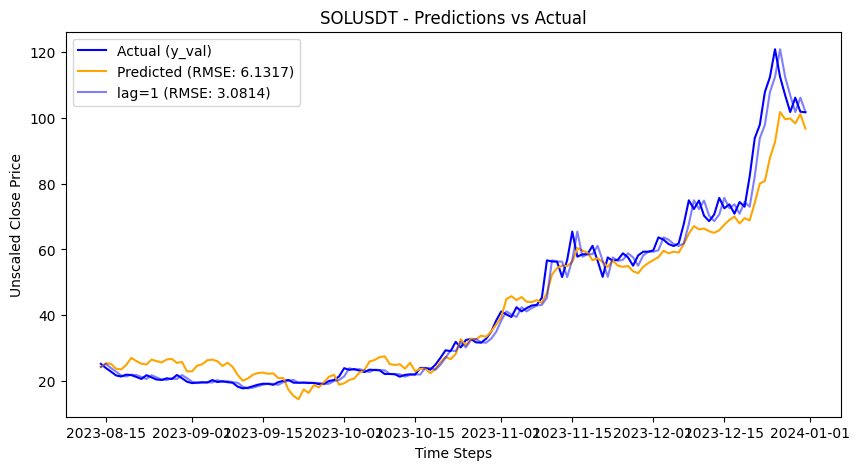

BTCUSDT - Linear Predictor RMSE: 746.6366
BTCUSDT - Predictions RMSE: 1212.2901


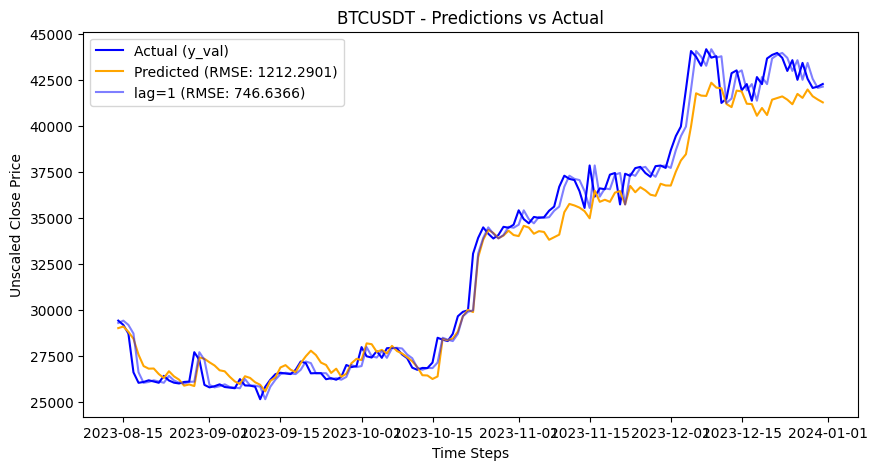

ETHUSDT - Linear Predictor RMSE: 46.2797
ETHUSDT - Predictions RMSE: 101.8802


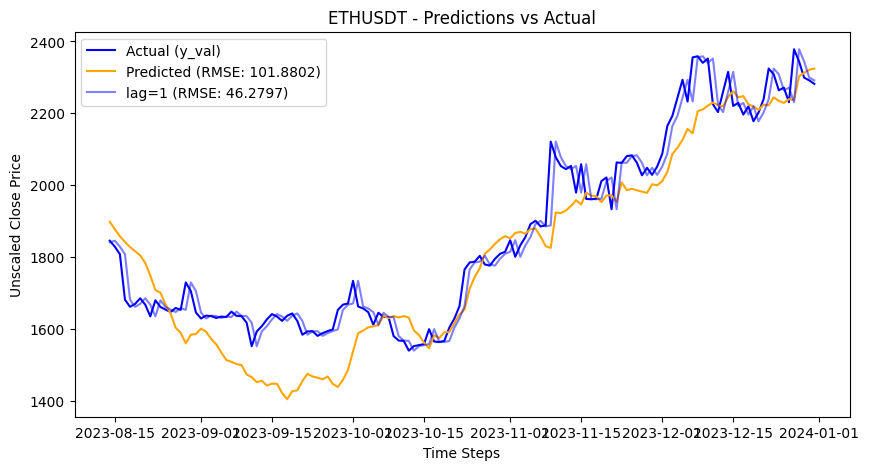

DOGEUSDT - Linear Predictor RMSE: 0.0023
DOGEUSDT - Predictions RMSE: 0.0032


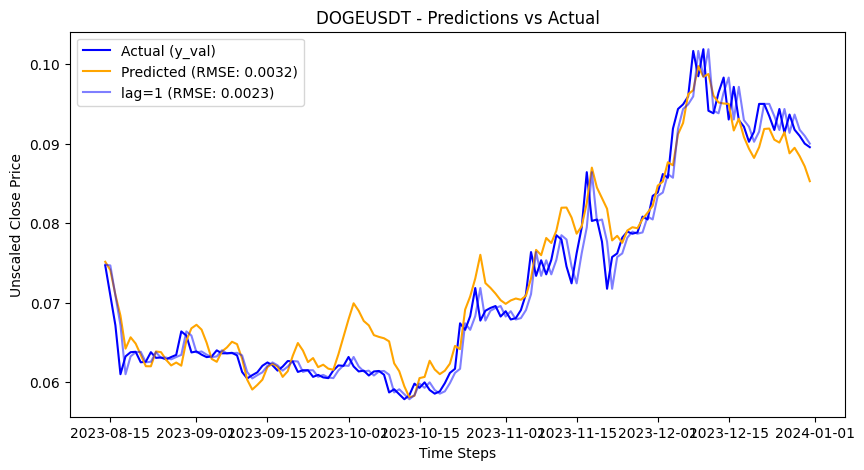

XRPUSDT - Linear Predictor RMSE: 0.0159
XRPUSDT - Predictions RMSE: 0.0218


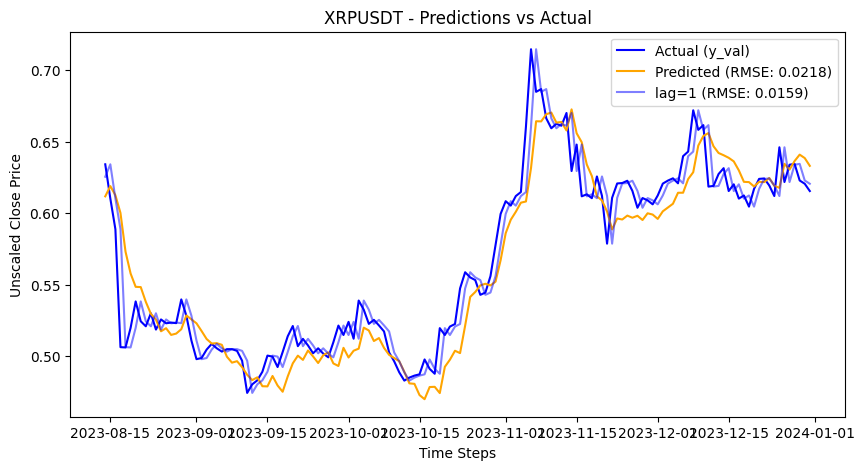

In [48]:
import matplotlib.pyplot as plt

# Plot predictions vs. actual values for each asset
for ticker, res in results.items():
    # Extract predictions and actual values
    preds = test_predictions[ticker]
    y_val = res['y_val']


    # Unscale predictions and actual values
    scaler = joblib.load(res['scaler_path'])
    seventeen_columns = pd.concat([preds] * 17, axis=1)
    preds_unscaled = scaler.inverse_transform(seventeen_columns)[:, 0]

    seventeen_columns = pd.concat([pd.DataFrame(y_val)] * 17, axis=1)
    y_val_unscaled = scaler.inverse_transform(seventeen_columns)[:, 0]

    # preds_unscaled = scaler.inverse_transform(
    #     np.concatenate([np.zeros((len(preds), len(scaler.min_)-1)), preds.values.reshape(-1, 1)], axis=1)
    # )[:, -1]
    # y_val_unscaled = scaler.inverse_transform(
    #     np.concatenate([np.zeros((len(y_val), len(scaler.min_)-1)), y_val.reshape(-1, 1)], axis=1)
    # )[:, -1]
    
    df = data.load_asset(ticker, sampling='1d')
    df = data.add_fear_and_greed(df)
    df = add_technical_features(df)
    df = df[(df.index >= '2022-01-01') & (df.index <= '2023-12-31')]
    # Add a "linear predictor" column
    N = 5  # Define the rolling window size
    df['linear_predictor'] = df['Close'].rolling(window=1).mean().shift(1)
    lin_preds = df.loc[preds.index, 'linear_predictor']
    
    # Plot

    # Calculate RMSE for linear predictor and predictions
    lin_rmse = np.sqrt(mean_squared_error(y_val_unscaled, lin_preds))
    preds_rmse = np.sqrt(mean_squared_error(y_val_unscaled, preds_unscaled))
    print(f"{ticker} - Linear Predictor RMSE: {lin_rmse:.4f}")
    print(f"{ticker} - Predictions RMSE: {preds_rmse:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(preds.index, y_val_unscaled, label=f'Actual (y_val)', color='blue')
    plt.plot(preds.index, preds_unscaled, label=f'Predicted (RMSE: {preds_rmse:.4f})', color='orange')
    plt.plot(lin_preds, label=f'lag=1 (RMSE: {lin_rmse:.4f})', color='blue', alpha=0.5)
    plt.title(f"{ticker} - Predictions vs Actual")
    plt.xlabel("Time Steps")
    plt.ylabel("Unscaled Close Price")
    plt.legend()
    plt.show()

In [49]:
preds_unscaled

array([0.6118867 , 0.6190485 , 0.6126856 , 0.60029185, 0.57316595,
       0.55792135, 0.54859364, 0.54842013, 0.5381094 , 0.52971935,
       0.5257074 , 0.5174998 , 0.5196571 , 0.51497024, 0.51589507,
       0.51894397, 0.52857137, 0.52583617, 0.5230732 , 0.5177079 ,
       0.5120944 , 0.50895876, 0.50918335, 0.50804734, 0.4997083 ,
       0.49556783, 0.4965933 , 0.49239576, 0.48707068, 0.4833664 ,
       0.4852896 , 0.47908294, 0.47895545, 0.48624718, 0.47957504,
       0.47520983, 0.48590285, 0.49507758, 0.5004647 , 0.49749675,
       0.5040737 , 0.4999451 , 0.4953155 , 0.50076205, 0.5027563 ,
       0.49502385, 0.49322948, 0.50593203, 0.4991631 , 0.50390446,
       0.50536376, 0.52004695, 0.5180655 , 0.5106956 , 0.5127648 ,
       0.5058921 , 0.501019  , 0.49883902, 0.49657768, 0.48917577,
       0.48106837, 0.4807431 , 0.47289336, 0.46998295, 0.47851127,
       0.47866073, 0.47427973, 0.49265006, 0.49763384, 0.5038874 ,
       0.50222653, 0.52140474, 0.5415534 , 0.5449914 , 0.54960

In [50]:
preds.index

DatetimeIndex(['2023-08-14', '2023-08-15', '2023-08-16', '2023-08-17',
               '2023-08-18', '2023-08-19', '2023-08-20', '2023-08-21',
               '2023-08-22', '2023-08-23',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', name='Open time', length=140, freq=None)